# Water sloshing experiment in a tank

We analyze experimental data generated Bäuerlein and Avila (Bäuerlein, Avila, JFM, 2021) for forced and unforced fluid sloshing in a tank. Previous studies of this data set used nonlinear Spectral Submanifold (SSM)-reduction to predict forced response (see Cenedese et al., Nat. Commun, 2022). We use DMD and DDL to extract and compare linear reduced-order models from unforced trajectory data, then use them to predict and verify forced response curves obtained from forced trajectory data. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

We first load the data, which has already been used for SSM-based reduced-order modeling by Cenedese et al. 2022, Axas et al., 2022 and Axas et al. 2023.

In [2]:

amplitudes = [0.09, 0.17, 0.32]
datadir = 'data/'
xData = loadmat(datadir + 'xData')['xData']
decayFrequencies = [0.953, 0.960, 0.967]
titles = []
for iFreq in range(len(decayFrequencies)):
    titles.append('$\Omega = ' + str(decayFrequencies[iFreq]) + '$')
indTrain = [0, 2]
indTest = [1]

In [3]:
t_test = np.squeeze(xData[indTest, 0][0])
x_test = xData[indTest, 1][0]

Text(0, 0.5, 'Amplitude')

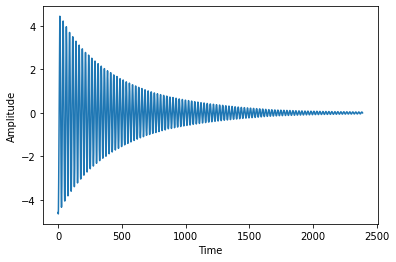

In [4]:
plt.plot(x_test[0])
plt.xlabel('Time')
plt.ylabel('Amplitude')

In [5]:
from data_driven_linearization.linearization import DataDrivenLinearization
from data_driven_linearization.dmd import dmd
from data_driven_linearization.edmd import edmd
from data_driven_linearization.embedding import coordinates_embedding


In [6]:
t_train = list(xData[indTrain, 0])
x_train = list(xData[indTrain, 1])

Recover the manifold in observable space via delay embedding

In [7]:
truncate_ = 200
overembed_dim = 0

In [8]:
embedding_output = coordinates_embedding([t_train[0][0,truncate_:], t_train[1][0,truncate_:], t_test[truncate_:]], 
                                         [x_train[0][:,truncate_:], x_train[1][:,truncate_:], x_test[:,truncate_:]], 
                                         imdim = 2, over_embedding = overembed_dim)


In the observable space, the tangent space of the 2D SSM is approximated via SVD. The coordinated 

$$
\varphi_1, \varphi_2
$$

are obtained by projection onto the leading singular modes.

In [9]:
x = embedding_output[1][:2]
times = embedding_output[0][:2]
times_test = embedding_output[0][2:]
x_test = embedding_output[1][2:]

In [10]:
U, S, V = np.linalg.svd(np.hstack(x), full_matrices=False)

In [11]:

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 16,"font.family": "serif",})

In [12]:
projected = [(U[:,:2] / S[:2]).T@x_train  for x_train in x]
projected_test =  [(U[:,:2] / S[:2]).T@x_  for x_ in x_test]

Text(0, 0.5, '$\\varphi_2$')

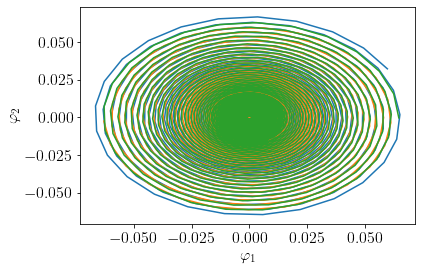

In [13]:
plt.plot(projected[0][0,:], projected[0][1,:])
plt.plot(projected[1][0,:], projected[1][1,:])

plt.plot(projected_test[0][0,:], projected_test[0][1,:])
plt.xlabel('$\\varphi_1$')
plt.ylabel('$\\varphi_2$')


## DDL model

We fit a 5th order DDL model, with an initial guess starting from the DMD-model

In [23]:
degree = 5
d = DataDrivenLinearization(2, degree = degree)

Dmd = dmd([projected[0][:, :]])

d.fit(projected, alpha = 0., method = 'with_inverse',
                            initial_transformation = 'zero',
              initial_matrix= Dmd.coef_, method_optimization ='trf', verbose = True)
init = 0 # can be used to truncate the dataset
transformed = d.transform(projected_test[0][:, init:])
predicted_ddl = d.predict(projected_test[0][:,init], projected_test[0][:,init:].shape[1]-1)
predicted_ddl = np.array(predicted_ddl)
reconstructed_ddl = d.inverse_transform(predicted_ddl)


Initial cost:  2.4871933737313824e-05
     message: `gtol` termination condition is satisfied.
     success: True
      status: 1
         fun: [-1.353e-04 -1.614e-04 ... -1.299e-09 -2.623e-09]
           x: [ 9.633e-01 -2.501e-01 ...  5.470e+02 -8.856e+03]
        cost: 5.265817031383942e-06
         jac: [[ 6.505e-02 -5.537e-03 ...  0.000e+00 -0.000e+00]
               [ 6.419e-02  1.115e-02 ...  0.000e+00 -0.000e+00]
               ...
               [ 0.000e+00 -0.000e+00 ...  0.000e+00 -8.215e-16]
               [ 0.000e+00 -0.000e+00 ...  0.000e+00 -8.215e-16]]
        grad: [-5.020e-12  1.583e-12 ...  4.383e-15 -1.870e-15]
  optimality: 5.020021920999727e-12
 active_mask: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
        nfev: 70
        njev: 62
Final cost:  1.0531634062767878e-05


In [24]:
d.linear_model

array([[ 0.96333775, -0.25010237],
       [ 0.25632727,  0.96721712]])

### Predict the test trajectory

We will use the continuous version of the model, obtained as

$$
B_{disc.} = e^{B_{cont}. \Delta t}
$$

In [25]:
v, w = np.linalg.eig(d.linear_model)

dt = t_train[0][0][1] - t_train[0][0][0]
Diag_cont = np.diag(np.log(v) / dt)

Comparing the DMD and DDL eigenvalues: 

In [26]:
np.log(np.linalg.eig(Dmd.coef_)[0])/dt

array([-0.06610096+7.73222897j, -0.06610096-7.73222897j])

In [27]:
np.log(np.linalg.eig(d.linear_model)[0])/dt

array([-0.06278409+7.77325222j, -0.06278409-7.77325222j])

In [28]:
reconstructed_ddl = reconstructed_ddl

In [29]:
reconstructed_ddl = np.array((U[:,:2]*S[:2])@reconstructed_ddl)
                              

In [30]:
#import distinctipy 
#colors2 = distinctipy.get_colors(10, n_attempts = 7000, rng = 1, colorblind_type='Tritanopia')
#distinctipy.color_swatch(colors2)

In [31]:
colors2 = [(0.03678484251536762, 0.6179966849702221, 0.9739358488787938),
 (0.9973991938671649, 0.271843841793703, 0.3312661650034482)]

Text(0, 0.5, 'Amplitude [$\\%$]')

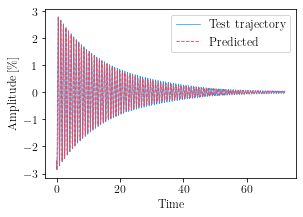

In [32]:

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 12,"font.family": "serif",})
width = 6.85 / 2
ratio = 8/6
height = width / ratio
fig = plt.figure(figsize = (4.5,3.1))#figsize =(width, height))
ax = fig.add_subplot(111)

plt.plot(times_test[0]-6.6, x_test[0][0,:], '-', c=colors2[0], linewidth =0.7, label ='Test trajectory')
plt.plot(times_test[0][init:]-6.6, reconstructed_ddl[0,:],'--', linewidth = 0.9,  c=colors2[1], label = 'Predicted')
#plt.xlim(0, 24)
plt.xlabel('Time')
plt.legend(loc = 'upper right')
plt.ylabel('Amplitude [$\%$]')
#plt.savefig('figs/sloshing_reconstruction_.pdf', bbox_inches='tight')

## DMD

In [33]:
Dmd = dmd(projected)
Dmd.coef_

array([[ 0.96366209, -0.25265003],
       [ 0.2514522 ,  0.9673185 ]])

In [34]:
def predict_(x0, times):
    out = [x0]
    for i in range(times):
        out.append(Dmd.coef_@(out[-1]))
    return np.array(out).T

In [35]:

predicted_dmd = predict_(projected_test[0][:,init], projected_test[0][:,init:].shape[1]-1)
predicted_dmd = np.array(predicted_dmd)
#reconstructed_ddl = d.inverse_transform(predicted_ddl)
reconstructed_dmd = np.array((U[:,:2]*S[:2])@predicted_dmd)


Text(0, 0.5, 'Amplitude [$\\%$]')

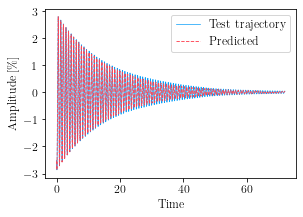

In [36]:

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 12,"font.family": "serif",})
width = 6.85 / 2
ratio = 8/6
height = width / ratio
fig = plt.figure(figsize = (4.5,3.1))#figsize =(width, height))
ax = fig.add_subplot(111)

plt.plot(times_test[0]-6.6, x_test[0][0,:], '-', c=colors2[0], linewidth =0.7, label ='Test trajectory')
plt.plot(times_test[0][init:]-6.6, reconstructed_dmd[0,:],'--', linewidth = 0.9,  c=colors2[1], label = 'Predicted')
#plt.xlim(0, 24)
plt.xlabel('Time')
plt.legend(loc = 'upper right')
plt.ylabel('Amplitude [$\%$]')


## Prediction of the forced response 

After fitting the DDL model, we obtain the linearizing transformation
$$
\varphi=\kappa\left(\gamma\right)=\gamma+\ell(\gamma),
$$

which linearizes the system as 
$$
\dot{\gamma}=B\gamma.
$$

Under the addition of a forcing term proportional to a forcing amplitude $\varepsilon$, the linearized system is modified as 

$$
\dot{\gamma}=B\gamma +\varepsilon(I+D\ell(\gamma))^{-1}\hat{F}(0,t),
$$
where $\hat{F}$ is the forcing vector in the observable space.

Since we have no explicit knowledge of $\hat{F}$, we follow the approach outlined in Cenedese et al. 2022 and calibrate the forcing amplitudes to a single forced experiment. 
Note, that DMD can also be treated in the same way, if we assume $\varphi = \gamma$, i.e., that the transformation $\kappa(\gamma)$ is the identity.


In [101]:
v, w = np.linalg.eig(d.linear_model)

dt = t_train[0][0][1] - t_train[0][0][0]
Diag_cont = np.diag(np.log(v) / dt)

In [102]:
def transform_to_diagonal(x,w):
    return np.linalg.inv(w)@x

In [103]:
Cont_non_diag = np.real(w@Diag_cont@np.linalg.inv(w))

In [104]:
frcExp = []
frcExp.append(np.loadtxt('data/Measurements_A=0.09%.txt', skiprows = 1))
frcExp.append(np.loadtxt('data/Measurements_A=0.17%.txt', skiprows = 1))
frcExp.append(np.loadtxt('data/Measurements_A=0.32%.txt', skiprows = 1))
amplitudes = [0.09, 0.17, 0.32]
decayFrequencies = [0.953, 0.960, 0.967]





We select the amplitude and the frequency of a single forced response experiment

In [105]:
calibOmega = frcExp[0][0,0] * 7.8
calibAmp = frcExp[0][0,1] 


($\Omega$, Amplitude):

In [106]:
calibOmega, calibAmp

(7.5347220342888, 0.369892216559)

In [107]:
#omega = np.imag(Diag_cont[0,0])
#alpha = np.real(Diag_cont[0,0])
#fsq = np.sqrt(calibAmp**2 * ((calibOmega - omega)**2 + alpha**2))

To evaluate the forced response of the linearized model, we require the Jacobian of the linearizing transformation. This can be precomputed symbolically. 

In [44]:
import sympy as sy

In [45]:
from data_driven_linearization.differentiation_utils import differentiate_model_symbolic

In [287]:
inverse_transform, inverse_derivative, variables = differentiate_model_symbolic(
    d.poly,
    d.inverse_transformation_model.coef_)

In [288]:
transform, derivative, variables = differentiate_model_symbolic(
    d.poly,
    d.transformation_coefficients)

In [289]:
inverse_transform_numpy = sy.lambdify([variables], inverse_transform, 'numpy')
derivative_transform_numpy = sy.lambdify([variables], derivative, 'numpy')
transform_numpy = sy.lambdify([variables], transform, 'numpy')
inverse_derivative_transform_numpy = sy.lambdify([variables], inverse_derivative, 'numpy')


Here we also show an approximation for the validity of this transformation. Since for the transformation $\kappa(\varphi)$, it has to hold that

$$
\kappa^{-1}\left(\kappa(\varphi)\right) = \varphi,
$$

we get a good approximation for the range of validity of the linearization by evaluating $\kappa^{-1}\left(\kappa(\varphi)\right)$. For example, along the diagonal $\varphi_1 = \varphi_2$ we obtain the following

(-0.06, 0.06)

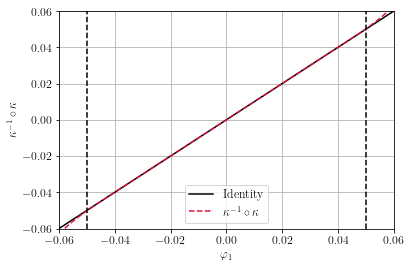

In [54]:
xx = np.linspace(-0.06, 0.06, 1000)
pts = np.vstack((xx, xx))

yy = np.squeeze(inverse_transform_numpy(np.squeeze(transform_numpy(pts))))
plt.plot(xx, xx, '-', c= 'black', label = 'Identity')
plt.plot(xx, yy[0,:], '--', c='crimson', label = '$\kappa^{-1}\circ \kappa $')
plt.grid()
plt.plot([-0.05, -0.05],[-0.06, 0.06], '--', c='black')
plt.plot([0.05, 0.05],[-0.06, 0.06], '--', c='black')

plt.legend()
plt.xlabel(u'$\\varphi_1$')
plt.ylabel(u'$\\kappa^{-1} \\circ \\kappa$')
plt.xlim(-0.06, 0.06)
plt.ylim(-0.06, 0.06)


Which suggests that the linearization is valid in the range $|\varphi_1|<0.05$. This corresponds to the range of the training data. 

### Computation with DDL

In [55]:
def simulate_forced(t, x, forcing):
    xx = x.reshape(-1,1)
    xx = inverse_transform_numpy(xx)
    derivative = derivative_transform_numpy(xx)
    return Cont_non_diag @ x + np.matmul(np.squeeze(derivative), forcing(t))

In [241]:
Cont_non_diag

array([[-1.22335199e-01, -7.67851081e+00],
       [ 7.86962445e+00, -3.23298947e-03]])

In [56]:
omegas = np.linspace(6., 9., 200)


In [57]:
from tqdm import tqdm

In [58]:
from scipy.integrate import solve_ivp

In [278]:
def calibrate(frc_amp, frc_freq):
    calib_orbit = frc_amp * np.sin(frc_freq * 7.8 * t_train[0])
    calib_orbit_derivative = frc_freq * 7.8 * frc_amp * np.cos(frc_freq*7.8 * t_train[0])
    calib_forcing = np.sin(frc_freq * 7.8 * t_train[0])
    embedding_output = coordinates_embedding([t_train[0][0,:],t_train[0][0,:], t_train[0][0,:]], 
                                         [calib_orbit, calib_orbit_derivative, calib_forcing], 
                                         imdim = 2, over_embedding = overembed_dim)
    times_calib = embedding_output[0][0]
    calib_orbit_embedded = embedding_output[1][0]
    calib_orbit_embedded_derivative = embedding_output[1][1]
    calib_forcing_embedded = embedding_output[1][2]
    projected_calib_orbit = (U[:,:2]/S[:2]).T@calib_orbit_embedded #[0,:]#, calib_orbit_embedded[1,:])
    projected_calib_orbit_derivative = (U[:,:2]/S[:2]).T@calib_orbit_embedded_derivative #[0,:]#, calib_orbit_embedded[1,:])
    projected_calib_forcing = (U[:,:2]/S[:2]).T@calib_forcing_embedded
    projected_calib_orbit_diag = transform_to_diagonal(projected_calib_orbit, w)
    projected_calib_forcing_diag = transform_to_diagonal(projected_calib_forcing, w)
    residual = projected_calib_orbit_derivative - Cont_non_diag@projected_calib_orbit
    return np.max(residual[0,:]), np.max(residual[1,:])

In [279]:
ind = 0#np.argmax(frcExp[0][:,1])

Since the largest amplitude FRC is outside the range of the training data, we only compute the FRC for the first two experiments.

In [280]:
indices = [0, 1]

In [281]:
omegas = np.linspace(6., 9., 200)
omegas2 = np.copy(omegas)
omegas2[np.logical_and(omegas2< 8.5, omegas2 > 7.55)] = np.nan 

In [282]:
f1, f2 = calibrate(frcExp[1][ind,1], frcExp[1][ind,0])


In [283]:
f1

0.001156033962209868

In [284]:
f2

0.009135225926241913

In [285]:
forcing = lambda t : np.array([f1, f2])*np.sin(o*t)


In [303]:
ic = np.array([0.1, 0.00])

In [304]:
simulate_forced(0, ic, forcing)

array([-0.01223352,  0.78696244])

In [63]:
%%time
response_ddl = []
for index in tqdm(indices): 
    results_integration_lin_ddl = []
    results_integration_lin_ddl_firstorder = []
    f1, f2 = calibrate(frcExp[index][ind,1], frcExp[index][ind,0])
    omegs = omegas
    if index == 2:
        omegs = omegas2
    for o in omegs:
        if o is np.nan:
            results_integration_lin_ddl.append(np.zeros((2, 100)))
            continue
        omm = o
        forcing = lambda t : np.array([f1, f2])*np.sin(o*t)
        if len(results_integration_lin_ddl)> 0:
            ic = results_integration_lin_ddl[-1][:, - 1]
        else:      
            ic = [0.00, 0.00]
        period = 2 *np.pi / omm
        converged = np.linspace(0, period, 100)

        sol = solve_ivp(simulate_forced, [0, 150 * period], 
                        ic, args = (forcing,),
                        method ='DOP853', atol = 1e-6)
        
        sol = solve_ivp(simulate_forced, [0, period], sol.y[:,-1],
                        t_eval = converged, args = (forcing,),
                        method ='DOP853', atol = 1e-6 )
        results_integration_lin_ddl.append(sol.y)
        
        
        
    results_lin_ddl = [np.array([d.inverse_transform(r)]) for r in results_integration_lin_ddl]
#    print(results_lin_ddl[0].shape)
    results_lin_ddl = [np.array([(U[:,:2]*S[:2])@r  for r in results_lin_ddl])]


    response = {}
    response['amplitudes'] = [f1, f2]
    response['results_lin_ddl'] = results_lin_ddl

    response_ddl.append(response)
    

 50%|███████████████████████████████████████████████████████████████████                                                                   | 1/2 [04:23<04:23, 263.06s/it]<lambdifygenerated-1>:3: RuntimeWarning: overflow encountered in power
  return array([[-10204.9639768577*x_0**5 - 790.898873313164*x_0**4*x_1 - 1.28847065873708*x_0**4 - 19057.1096582585*x_0**3*x_1**2 - 0.609070129806198*x_0**3*x_1 + 12.9460969385562*x_0**3 - 127.771977893964*x_0**2*x_1**3 + 10.7133075872423*x_0**2*x_1**2 - 132.309567576703*x_0**2*x_1 - 0.0108265178336482*x_0**2 - 8502.82154405547*x_0*x_1**4 + 5.53140080333448*x_0*x_1**3 + 8.27437603764303*x_0*x_1**2 - 0.00866263060924656*x_0*x_1 + 1.0*x_0 + 82.0950052564945*x_1**5 + 6.46758429486093*x_1**4 - 130.004745421094*x_1**3 - 0.0473903254516223*x_1**2], [-1423.43814557201*x_0**5 - 8764.74258109068*x_0**4*x_1 + 6.2744300298044*x_0**4 - 977.253093389627*x_0**3*x_1**2 - 5.0813738325623*x_0**3*x_1 + 139.189386739725*x_0**3 - 17983.3429576666*x_0**2*x_1**3 - 4.809

CPU times: user 9min 9s, sys: 1.24 s, total: 9min 10s
Wall time: 9min 10s


In [64]:
results_lin_ddl = [np.squeeze(r) for r in results_lin_ddl]

In [65]:
results_integration_lin_ddl_ = []
for r in results_integration_lin_ddl:
    if r.shape[1] == 100:
        results_integration_lin_ddl_.append(r)

In [66]:
results_lin_ddl = [np.array([(U[:,:2]*S[:2])@r  for r in results_integration_lin_ddl_])]


In [67]:
response = {}
response['amplitudes'] = [f1, f2]
response['results_lin_ddl'] = results_lin_ddl

In [68]:
omegas2_ = omegas2[:len(results_integration_lin_ddl_)]

In [69]:
response_ddl.append(response)

In [70]:
ratios = amplitudes/f2

In [259]:
ratios

array([ 9.85197309, 18.6092825 , 35.02923765])

In [78]:
#colors = distinctipy.get_colors(5, n_attempts = 3000, rng = 6)
#distinctipy.color_swatch(colors)


In [79]:
colors = [(0.0, 0.5, 1.0), (1.0, 0.5, 0.0), (0.5, 0.25, 0.5)]

(200, 1, 5, 100)
(200, 1, 5, 100)


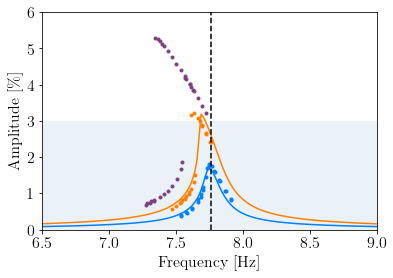

In [80]:

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 16,"font.family": "serif",})
width = 6.85 / 2
ratio = 8/6
height = width / ratio
fig = plt.figure()#figsize =(width, height))
ax = fig.add_subplot(111)

toplot_ddl = [response_ddl[0],response_ddl[1]]#,response_ddl[2]] #[response_ddl[0], response_ddl[1], response_ddl[2]]


for i, respddl in enumerate(toplot_ddl):
    print(respddl['results_lin_ddl'][0].shape)
    amps_lin = [np.max(np.abs(r[0,0,:])) for r in respddl['results_lin_ddl'][0]]

    ax.plot(omegas, amps_lin, '-', c=colors[i])

    ind = np.argmax(amps_lin)

ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude [\%]')
for i in range(3):
    ax.plot(frcExp[i][:,0]*7.8, frcExp[i][:,1], '.', c= colors[i])
plt.plot([7.76, 7.76], [0, 6.],'--', c='blacK')
#ax.set_xlim(1.2, 1.6)
#ax.set_ylim(0, 5)
plt.ylim(0, 6.0)
plt.xlim(6.5, 9)
ax.axhspan(0,3, alpha=0.09)



### Computation with DMD

We repeat the same calibration, and forced response prediction for the DMD model

In [83]:
v, w = np.linalg.eig(Dmd.coef_)

dt = t_train[0][0][1] - t_train[0][0][0]
Diag_cont_dmd = np.diag(np.log(v) / dt)

In [84]:
Cont_non_diag_dmd = np.real(w@Diag_cont_dmd@np.linalg.inv(w))

In [85]:
def simulate_forced_dmd(t, x, forcing):
    xx = x.reshape(-1,1)
    return Cont_non_diag_dmd @ x + forcing(t)

In [92]:
ind = 0

In [93]:
#%%time
response_dmd = []
for index in tqdm(range(2)): 
    results_integration_lin_dmd = []
    f1, f2 = calibrate(frcExp[index][ind,1], frcExp[index][ind,0])
    omegs = omegas
    if index == 2:
        omegs = omegas2
    for o in omegs:
        if o is np.nan:
            results_integration_lin_dmd.append(np.zeros((2, 100)))
            continue
        omm = o
        forcing = lambda t : np.array([f1, f2])*np.sin(o*t)
        if len(results_integration_lin_dmd)> 0:
            ic = results_integration_lin_dmd[-1][:, - 1]
        else:      
            ic = [0.00, 0.00]
        period = 2 *np.pi / omm
        converged = np.linspace(0, period, 100)

        sol = solve_ivp(simulate_forced_dmd, [0, 150 * period], 
                        ic, args = (forcing,),
                        method ='DOP853', atol = 1e-6)
        
        sol = solve_ivp(simulate_forced, [0, period], sol.y[:,-1],
                        t_eval = converged, args = (forcing,),
                        method ='DOP853', atol = 1e-6 )
        results_integration_lin_dmd.append(sol.y)
        
        results_lin_dmd = [np.array([(U[:,:2]*S[:2])@r  for r in results_integration_lin_dmd])]


    response = {}
    response['amplitudes'] = [f1, f2]
    response['results_lin_dmd'] = results_lin_dmd

    response_dmd.append(response)
    

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:29<00:00, 14.93s/it]


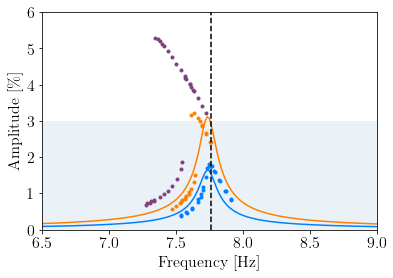

In [94]:

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 16,"font.family": "serif",})
width = 6.85 / 2
ratio = 8/6
height = width / ratio
fig = plt.figure()#figsize =(width, height))
ax = fig.add_subplot(111)



for i, resp in enumerate(response_dmd):
    amps_lin = [np.max(np.abs(r[:, 0,:]), axis = 1) for r in resp['results_lin_dmd']]
    ax.plot(omegas, np.squeeze(amps_lin), '-', c=colors[i])
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude [\%]')
for i in range(3):
    ax.plot(frcExp[i][:,0]*7.8, frcExp[i][:,1], '.', c= colors[i])
plt.plot([7.76, 7.76], [0, 6.],'--', c='blacK')

plt.ylim(0, 6.)
plt.xlim(6.5, 9)
ax.axhspan(0,3, alpha=0.09)
